In [1]:
import sys
sys.path.append("..")
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

import matplotlib.pyplot as plt
import numpy as np

from coordination.model.real.vocalic_2d import VocalicModel
from coordination.model.real.vocalic_2d_semantic_link import VocalicSemanticLinkModel
from coordination.model.config_bundle.vocalic import Vocalic2DConfigBundle
from coordination.model.config_bundle.vocalic_semantic_link import Vocalic2DSemanticLinkConfigBundle
from coordination.module.coordination.sigmoid_gaussian_coordination import SigmoidGaussianCoordinationSamples
from coordination.model.model import ModelSamples

In [2]:
# Functions
def plot_state_space(samples: ModelSamples):
    subject_indices = samples.component_group_samples["state_space"].subject_indices[0]
    values = samples.component_group_samples["state_space"].values[0]
    fig, axs = plt.subplots(1, 2, figsize=(15,4))	
    for subject in range(3):
        ts = np.array([t for t, s in enumerate(subject_indices) if s == subject])
        ys = values[:, ts]
        axs[0].plot(ts, ys[0], label=f"Subject {subject + 1}")
        axs[1].plot(ts, ys[1], label=f"Subject {subject + 1}")

    axs[0].set_title("Position")
    axs[1].set_title("Speed")
    plt.legend()  

def plot_links(samples: ModelSamples):
    ts = samples.component_group_samples["semantic_link"].time_steps_in_coordination_scale[0]
    ys = np.ones_like(ts)
    fig = plt.figure(figsize=(6,4))	
    plt.scatter(ts, ys, label=f"Semantic Link", marker="o")
    plt.title("Semantic Links")
    plt.legend() 

# Sampling

## Coordination = 0

In the abcensse of coordination, each subject's component follows it's own dynamics whcih consists of a constant speed and position governed by a simple movement equation. See, for instance, that the position of the component from subject 3 increases faster than the others given its larger speed.

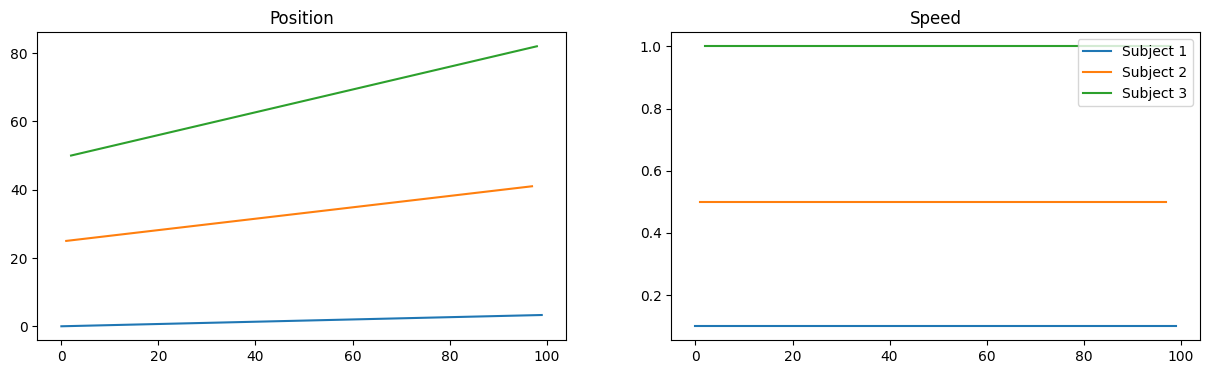

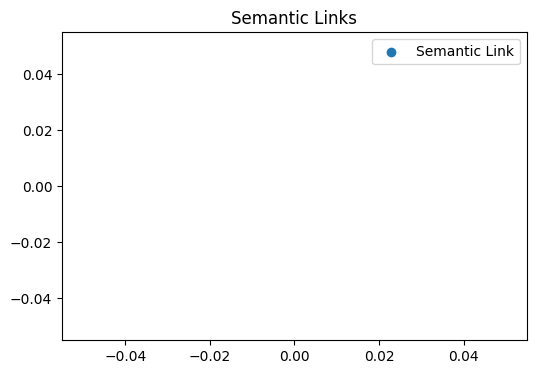

In [3]:
C = 0
T = 100
NOISE = 0.0
# bundle = Vocalic2DConfigBundle()
bundle = Vocalic2DSemanticLinkConfigBundle()
bundle.num_time_steps_in_coordination_scale = T
bundle.mean_a0 = np.array([[0,0.1], [25,0.5], [50,1]])
bundle.sd_a = np.array([NOISE])
bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=[np.ones(T) * C])
# model = VocalicModel(bundle)
model = VocalicSemanticLinkModel(bundle)
model.prepare_for_sampling()
samples = model.draw_samples()
plot_state_space(samples)
plot_links(samples)

## Coordination = 1

When coordination is maximum, the components instantly share the same speed which is a positive number in this example, leading to a constant increase in their position over time. Notice, however, that because we do not blend position, each component moves in its own scale, which would be equivalent to different people having different baselines for their biological signals. For instance, person A may have a natural lower picth than person B. Coordination will unlikely make person B to adopt person's B pitch but it may influence person A to increase their pitch with respect to person A's baseline if person B does the same with respect to their own pitch baseline.

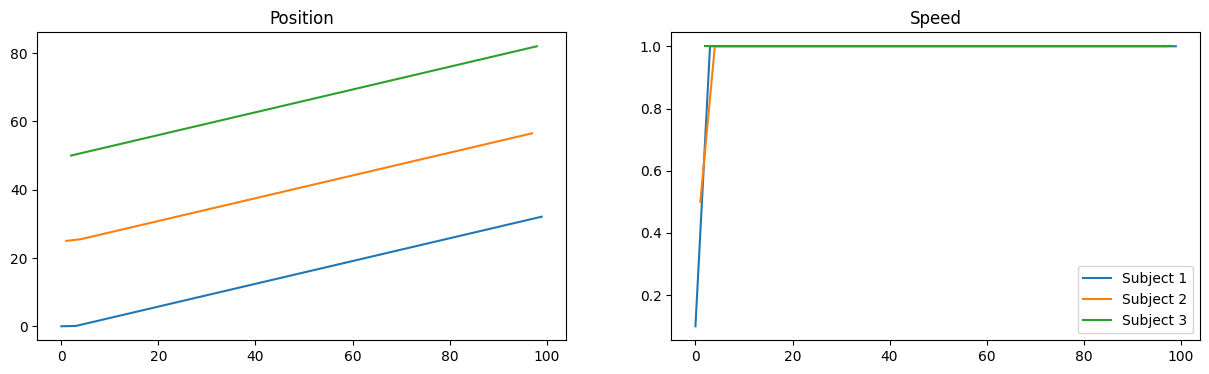

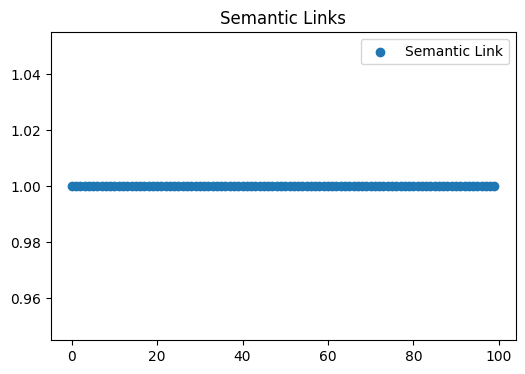

In [4]:
C = 1
T = 100
NOISE = 0.0
# bundle = Vocalic2DConfigBundle()
bundle = Vocalic2DSemanticLinkConfigBundle()
bundle.num_time_steps_in_coordination_scale = T
bundle.mean_a0 = np.array([[0,0.1], [25,0.5], [50,1]])
bundle.sd_a = np.array([NOISE])
bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=[np.ones(T) * C])
# model = VocalicModel(bundle)
model = VocalicSemanticLinkModel(bundle)
model.prepare_for_sampling()
samples = model.draw_samples()
plot_state_space(samples)
plot_links(samples)

## Coordination = 0.1

As we lower coordination, the slower the component's speed converge to a common value but it still does if coordination persists. This tells us that persistent non-zero coordination in this model leads to convergence given enough time and no noise in the system. There's probably an analytical form to find the time when the speeds converge given some conditions (no variance, no gaps etc.).

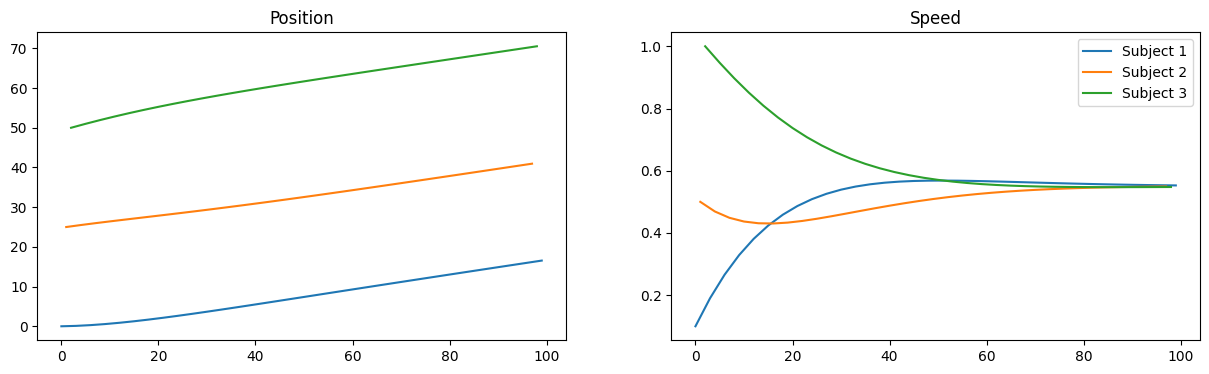

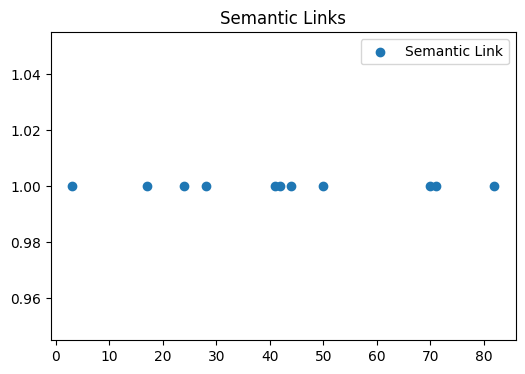

In [5]:
C = 0.1
T = 100
NOISE = 0.0
# bundle = Vocalic2DConfigBundle()
bundle = Vocalic2DSemanticLinkConfigBundle()
bundle.num_time_steps_in_coordination_scale = T
bundle.mean_a0 = np.array([[0,0.1], [25,0.5], [50,1]])
bundle.sd_a = np.array([NOISE])
bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=[np.ones(T) * C])
# model = VocalicModel(bundle)
model = VocalicSemanticLinkModel(bundle)
model.prepare_for_sampling()
samples = model.draw_samples()
plot_state_space(samples)
plot_links(samples)

## Inference

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [coordination_mean_uc0, coordination_sd_uc, unbounded_coordination, state_space_mean_a0, state_space, speech_vocalics_sd_o]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 201 seconds.


<Axes: xlabel='Time Step', ylabel='Coordination'>

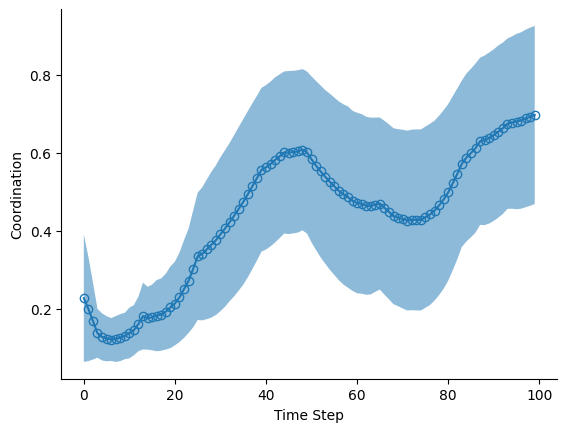

In [8]:
C = 0.1
T = 100
NOISE = 0
# bundle = Vocalic2DConfigBundle()
bundle = Vocalic2DSemanticLinkConfigBundle()
bundle.num_time_steps_in_coordination_scale = T
bundle.mean_a0 = np.array([[0,0.1], [25,0.5], [50,1]])
bundle.sd_a = np.array([0.01])
bundle.sd_o = np.array([0.01])
bundle.coordination_samples = SigmoidGaussianCoordinationSamples(unbounded_coordination=None, coordination=[np.ones(T) * C])
# model = VocalicModel(bundle)
model = VocalicSemanticLinkModel(bundle)
model.prepare_for_sampling()
samples = model.draw_samples()

# Use samples from the observed vocalics for inference.
# bundle.observed_values = samples.component_group_samples["speech_vocalics"].values[0]
bundle.observed_vocalic_values = samples.component_group_samples["speech_vocalics"].values[0]
bundle.subject_indices = samples.component_group_samples["speech_vocalics"].subject_indices[0]
bundle.prev_time_diff_subject = samples.component_group_samples["state_space"].prev_time_diff_subject[0]
bundle.prev_time_same_subject = samples.component_group_samples["state_space"].prev_time_same_subject[0]
# bundle.time_steps_in_coordination_scale = samples.component_group_samples["speech_vocalics"].time_steps_in_coordination_scale[0]
bundle.vocalics_time_steps_in_coordination_scale = samples.component_group_samples["speech_vocalics"].time_steps_in_coordination_scale[0]
bundle.semantic_link_time_steps_in_coordination_scale = samples.component_group_samples["semantic_link"].time_steps_in_coordination_scale[0]

# Infer the parameters below as well
bundle.sd_o = None
bundle.mean_a0 = None
bundle.mean_uc0 = None
bundle.sd_uc = None
bundle.p = None

model.clear_parameter_values()
model.prepare_for_inference()
model.create_random_variables()
idata = model.fit()
idata.plot_time_series_posterior(variable_name="coordination", include_bands=True, value_bounds=(0, 1))